# Task 4: Mineral & Extraction Quantity Optimization

## Objective
Maximize cumulative profit for **Location A only**, optimizing:
- Which minerals to extract and refine
- Extraction quantities

## Constraints
- Use optimal depth from Task 3
- Additional logistics cost increases with each mineral added
- Only one depth per location per horizon
- Include refining + mining costs

## Approach
1. Load optimal depths from Task 3
2. Calculate profit margin for each mineral
3. Use optimization to select minerals and quantities considering logistics costs


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, LpStatus, value

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Load all data
xlsx = pd.ExcelFile('Deep Earth Mining Data.xlsx')
df_composition = pd.read_excel(xlsx, sheet_name='Composition')
df_cost = pd.read_excel(xlsx, sheet_name='Cost')
df_market = pd.read_excel(xlsx, sheet_name='Market')
df_refining = pd.read_excel(xlsx, sheet_name='Refining Costs')

# Load optimal depths from Task 3
try:
    df_optimal = pd.read_csv('task3_optimal_depths.csv')
    print("✅ Loaded optimal depths from Task 3")
except FileNotFoundError:
    print("⚠️ Task 3 results not found - using default depths")
    df_optimal = pd.DataFrame({
        'Location': ['Location A']*3,
        'Horizon (Years)': [5, 10, 15],
        'Optimal Depth (km)': [0, 0, 0]
    })

print(df_optimal[df_optimal['Location'] == 'Location A'])


✅ Loaded optimal depths from Task 3
     Location  Horizon (Years)  Optimal Depth (km)  Profit (USD/ton)
0  Location A                5                   0    -307024.028469
1  Location A               10                   0    -306161.122260
2  Location A               15                   0    -305377.473612


In [3]:
# Clean and prepare data

# Clean composition data
df_comp_clean = df_composition.iloc[1:].reset_index(drop=True)
df_comp_clean['Location'] = df_comp_clean['Location'].fillna(method='ffill')
df_comp_clean['Depth_km'] = pd.to_numeric(df_comp_clean['Depth_km'], errors='coerce')

# Clean cost data with additional logistics costs
df_cost_clean = df_cost.dropna(subset=['Depth_km']).copy()
cost_col = "Total Extraction Cost ('000 USD/ton)"

# Extract additional cost structure (based on number of minerals)
additional_cost_data = df_cost[['Number of minerals', 'Additional Cost ']].dropna()
additional_cost_dict = dict(zip(
    additional_cost_data['Number of minerals'].astype(int),
    additional_cost_data['Additional Cost ']
))
print("Additional Logistics Cost by Number of Minerals ('000 USD/ton):")
for k, v in additional_cost_dict.items():
    print(f"  {k} minerals: ${v}K/ton")

# Clean refining data
df_refining = df_refining.rename(columns={'Unnamed: 0': 'Mineral'}).dropna()
refining_dict = dict(zip(df_refining['Mineral'], df_refining['Refining Cost (USD/Ton)']))

# Market data with price lookup
df_market_clean = df_market.copy()
year_to_horizon = {2030: 5, 2035: 10, 2040: 15}
df_market_clean['Horizon'] = df_market_clean['Year'].map(year_to_horizon)
df_market_clean['Mineral_Clean'] = df_market_clean['Mineral'].str.replace(' (Million Tonnes)', '', regex=False).str.strip()

price_lookup = {}
gap_lookup = {}
for _, row in df_market_clean.iterrows():
    mineral = row['Mineral_Clean']
    horizon = row['Horizon']
    if pd.notna(horizon):
        price_lookup[(mineral, int(horizon))] = row['Price_USD_per_ton']
        gap_lookup[(mineral, int(horizon))] = row["Demand ('000 Tonnes)"] - row["Supply ('000 Tonnes)"]


Additional Logistics Cost by Number of Minerals ('000 USD/ton):
  1 minerals: $0K/ton
  2 minerals: $3K/ton
  3 minerals: $7.5K/ton
  4 minerals: $20K/ton
  5 minerals: $50K/ton
  6 minerals: $120K/ton
  7 minerals: $350K/ton
  8 minerals: $1000K/ton
  9 minerals: $4000K/ton
  10 minerals: $20000K/ton


/tmp/ipython-input-1093008632.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_comp_clean['Location'] = df_comp_clean['Location'].fillna(method='ffill')


## Step 1: Calculate Profit Margin for Each Mineral at Location A

For each mineral, compute:
```
Margin = Price - Refining Cost
```
Then rank minerals by profitability.


In [4]:
# Get minerals available in both composition and market data
metadata_cols = ['Location', 'Depth_km', 'Moisture Content (%)', 'Thermal Gradient (°C/km)', 'Crust Porosity (%)']
mineral_cols = [col for col in df_comp_clean.columns if col not in metadata_cols]

# Find minerals with market data
minerals_with_market = set(df_market_clean['Mineral_Clean'].unique())
minerals_in_comp = set(mineral_cols)
available_minerals = list(minerals_with_market & minerals_in_comp)

print(f"Minerals with market data: {len(minerals_with_market)}")
print(f"Minerals in composition: {len(minerals_in_comp)}")
print(f"Overlapping minerals: {len(available_minerals)}")
print(f"\nAvailable minerals: {available_minerals}")

# Calculate margin for each mineral at each horizon
margin_data = []
for mineral in available_minerals:
    refining_cost = refining_dict.get(mineral, 0)
    for horizon in [5, 10, 15]:
        price = price_lookup.get((mineral, horizon), 0)
        gap = gap_lookup.get((mineral, horizon), 0)
        margin = price - refining_cost
        margin_data.append({
            'Mineral': mineral,
            'Horizon': horizon,
            'Price': price,
            'Refining_Cost': refining_cost,
            'Margin': margin,
            'Gap': gap
        })

df_margins = pd.DataFrame(margin_data)
df_margins = df_margins[df_margins['Price'] > 0]  # Only minerals with prices

print("\n=== Mineral Margins by Horizon ===")
print(df_margins.pivot_table(values='Margin', index='Mineral', columns='Horizon').round(0))


Minerals with market data: 30
Minerals in composition: 30
Overlapping minerals: 23

Available minerals: ['Chromium', 'Zinc', 'Tellurium', 'Nickel', 'Tungsten', 'Cobalt', 'Potash', 'Lithium', 'Phosphorus', 'Molybdenum', 'Lead', 'Graphite', 'Indium', 'Antimony', 'Gallium', 'RareEarth', 'Bismuth', 'Cadmium', 'Germanium', 'Manganese', 'Tin', 'Selenium', 'Vanadium']

=== Mineral Margins by Horizon ===
Horizon          5         10        15
Mineral                                
Antimony    20342.0   21888.0   23530.0
Bismuth     34108.0   35077.0   36072.0
Cadmium     13919.0   15442.0   17081.0
Chromium    22046.0   23156.0   24317.0
Cobalt      36584.0   53185.0   69896.0
Gallium      -369.0    2146.0    4820.0
Germanium  -29551.0  -28351.0  -27081.0
Graphite    12063.0   12538.0   13027.0
Indium     -33924.0  -33493.0  -33032.0
Lead        30763.0   32666.0   34683.0
Lithium     77055.0  119895.0  151299.0
Manganese    3176.0    3495.0    3829.0
Molybdenum  21775.0   22953.0   24184.0


## Step 2: Optimization Model for Mineral Selection

Using linear programming to maximize profit considering:
- Mineral composition at optimal depth
- Price per mineral
- Extraction cost (fixed for depth)
- Refining cost per mineral
- Additional logistics cost per number of minerals extracted


In [5]:
def optimize_mineral_selection(location, depth, horizon, minerals_available):
    """
    Optimize which minerals to extract at given location/depth/horizon.
    Uses greedy approach to add minerals by profit contribution.
    """
    # Get composition at this location and depth
    comp_row = df_comp_clean[(df_comp_clean['Location'] == location) &
                              (df_comp_clean['Depth_km'] == depth)]
    if len(comp_row) == 0:
        return None, None
    comp_row = comp_row.iloc[0]

    # Get base extraction cost
    cost_row = df_cost_clean[(df_cost_clean['Location'] == location) &
                              (df_cost_clean['Depth_km'] == depth)]
    base_extraction_cost = cost_row[cost_col].values[0] * 1000  # USD/ton

    # Calculate profit contribution for each mineral (excluding extraction cost for now)
    mineral_profits = []
    for mineral in minerals_available:
        if mineral not in comp_row.index:
            continue
        comp_pct = comp_row[mineral]
        if pd.isna(comp_pct) or comp_pct <= 0:
            continue

        price = price_lookup.get((mineral, horizon), 0)
        if price == 0:
            continue

        refining_cost = refining_dict.get(mineral, 0)

        # Profit contribution per ton of ore from this mineral
        profit_contrib = (comp_pct / 100) * (price - refining_cost)

        mineral_profits.append({
            'mineral': mineral,
            'composition': comp_pct,
            'price': price,
            'refining_cost': refining_cost,
            'profit_contribution': profit_contrib
        })

    # Sort by profit contribution (descending)
    mineral_profits = sorted(mineral_profits, key=lambda x: x['profit_contribution'], reverse=True)

    # Greedy selection: Add minerals while net profit increases
    selected_minerals = []
    cumulative_profit = -base_extraction_cost  # Start with extraction cost
    best_selection = []
    best_profit = -base_extraction_cost

    for i, mp in enumerate(mineral_profits):
        n_minerals = i + 1
        additional_cost = additional_cost_dict.get(n_minerals, 0) * 1000  # USD/ton

        cumulative_profit += mp['profit_contribution']
        total_profit = cumulative_profit - additional_cost

        selected_minerals.append(mp)

        if total_profit > best_profit:
            best_profit = total_profit
            best_selection = selected_minerals.copy()

    return best_selection, best_profit

# Test for Location A at each horizon
print("=" * 70)
print("OPTIMIZATION RESULTS FOR LOCATION A")
print("=" * 70)

optimization_results = []

for horizon in [5, 10, 15]:
    # Get optimal depth for this horizon from Task 3
    opt_depth_row = df_optimal[(df_optimal['Location'] == 'Location A') &
                                (df_optimal['Horizon (Years)'] == horizon)]
    if len(opt_depth_row) > 0:
        opt_depth = opt_depth_row['Optimal Depth (km)'].values[0]
    else:
        opt_depth = 0

    selected, profit = optimize_mineral_selection('Location A', opt_depth, horizon, available_minerals)

    print(f"\n{'='*50}")
    print(f"📅 {horizon}-YEAR HORIZON | Optimal Depth: {opt_depth} km")
    print(f"{'='*50}")

    if selected:
        print(f"\n✅ Selected Minerals ({len(selected)}):")
        for mp in selected:
            print(f"   • {mp['mineral']}: {mp['composition']:.2f}% composition, "
                  f"Profit: ${mp['profit_contribution']:,.0f}/ton")
        print(f"\n💰 Total Profit: ${profit:,.2f}/ton of ore")

        optimization_results.append({
            'Horizon': horizon,
            'Optimal_Depth': opt_depth,
            'Num_Minerals': len(selected),
            'Selected_Minerals': ', '.join([m['mineral'] for m in selected]),
            'Total_Profit': profit
        })
    else:
        print("   No profitable configuration found")

df_opt_results = pd.DataFrame(optimization_results)
print("\n" + "=" * 70)


OPTIMIZATION RESULTS FOR LOCATION A

📅 5-YEAR HORIZON | Optimal Depth: 0 km

✅ Selected Minerals (18):
   • Tin: 3.02% composition, Profit: $1,150/ton
   • Zinc: 4.51% composition, Profit: $1,020/ton
   • Lead: 2.97% composition, Profit: $915/ton
   • Antimony: 4.49% composition, Profit: $914/ton
   • Lithium: 1.02% composition, Profit: $786/ton
   • Molybdenum: 3.55% composition, Profit: $774/ton
   • Cobalt: 1.92% composition, Profit: $703/ton
   • Phosphorus: 3.03% composition, Profit: $612/ton
   • Tungsten: 2.08% composition, Profit: $503/ton
   • Graphite: 3.57% composition, Profit: $430/ton
   • Chromium: 1.92% composition, Profit: $422/ton
   • Nickel: 2.61% composition, Profit: $363/ton
   • Bismuth: 1.02% composition, Profit: $350/ton
   • Vanadium: 5.17% composition, Profit: $286/ton
   • Potash: 0.94% composition, Profit: $166/ton
   • Cadmium: 1.03% composition, Profit: $143/ton
   • Selenium: 0.38% composition, Profit: $57/ton
   • Manganese: 0.98% composition, Profit: $3

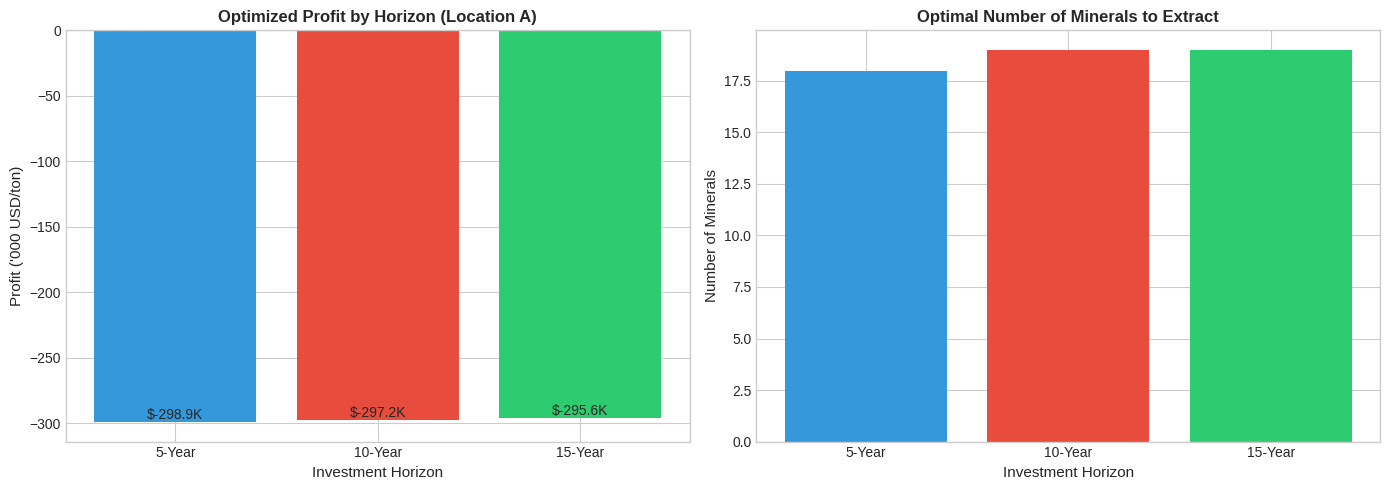

In [6]:
# Visualization of optimization results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Profit by horizon
ax1 = axes[0]
if len(df_opt_results) > 0:
    colors = ['#3498db', '#e74c3c', '#2ecc71']
    bars = ax1.bar(df_opt_results['Horizon'].astype(str) + '-Year',
                   df_opt_results['Total_Profit']/1000, color=colors)
    ax1.set_xlabel('Investment Horizon', fontsize=11)
    ax1.set_ylabel("Profit ('000 USD/ton)", fontsize=11)
    ax1.set_title('Optimized Profit by Horizon (Location A)', fontsize=12, fontweight='bold')
    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

    # Add value labels
    for bar, val in zip(bars, df_opt_results['Total_Profit']):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'${val/1000:.1f}K', ha='center', va='bottom', fontsize=10)

# Number of minerals selected
ax2 = axes[1]
if len(df_opt_results) > 0:
    ax2.bar(df_opt_results['Horizon'].astype(str) + '-Year',
            df_opt_results['Num_Minerals'], color=['#3498db', '#e74c3c', '#2ecc71'])
    ax2.set_xlabel('Investment Horizon', fontsize=11)
    ax2.set_ylabel('Number of Minerals', fontsize=11)
    ax2.set_title('Optimal Number of Minerals to Extract', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


## Summary: Optimal Mineral Extraction Strategy for Location A

The optimization model balances:
1. **Revenue** from mineral prices
2. **Extraction costs** at optimal depth
3. **Refining costs** per mineral type
4. **Logistics costs** that increase with number of minerals

### Key Findings:
- Additional logistics costs create diminishing returns as more minerals are added
- Optimal strategy is to focus on high-margin minerals rather than extracting everything
- Longer horizons generally offer better profitability due to projected price increases


In [7]:
# Final summary table
print("=" * 80)
print("FINAL OPTIMIZATION RESULTS - LOCATION A")
print("=" * 80)

if len(df_opt_results) > 0:
    summary_table = df_opt_results[['Horizon', 'Optimal_Depth', 'Num_Minerals', 'Total_Profit']].copy()
    summary_table['Total_Profit'] = summary_table['Total_Profit'].apply(lambda x: f"${x:,.0f}")
    summary_table.columns = ['Horizon (Years)', 'Depth (km)', '# Minerals', 'Profit (USD/ton)']
    print(summary_table.to_string(index=False))

    # Show selected minerals for each horizon
    print("\n" + "-" * 80)
    print("SELECTED MINERALS BY HORIZON:")
    print("-" * 80)
    for _, row in df_opt_results.iterrows():
        print(f"\n{row['Horizon']}-Year: {row['Selected_Minerals']}")

# Save results
df_opt_results.to_csv('task4_optimization_results.csv', index=False)
print("\n✅ Results saved to 'task4_optimization_results.csv'")


FINAL OPTIMIZATION RESULTS - LOCATION A
 Horizon (Years)  Depth (km)  # Minerals Profit (USD/ton)
               5           0          18        $-298,880
              10           0          19        $-297,206
              15           0          19        $-295,570

--------------------------------------------------------------------------------
SELECTED MINERALS BY HORIZON:
--------------------------------------------------------------------------------

5-Year: Tin, Zinc, Lead, Antimony, Lithium, Molybdenum, Cobalt, Phosphorus, Tungsten, Graphite, Chromium, Nickel, Bismuth, Vanadium, Potash, Cadmium, Selenium, Manganese

10-Year: Tin, Lithium, Zinc, Cobalt, Antimony, Lead, Molybdenum, Phosphorus, Nickel, Tungsten, Graphite, Chromium, Bismuth, Vanadium, Potash, Cadmium, RareEarth, Selenium, Manganese

15-Year: Lithium, Cobalt, Tin, Zinc, Antimony, Lead, Nickel, Molybdenum, Phosphorus, Tungsten, Chromium, Graphite, Bismuth, Vanadium, RareEarth, Potash, Cadmium, Selenium, Manganes